In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json
import pickle

In [2]:
torch.tensor([[1],[2],[3]]).squeeze()

tensor([1, 2, 3])

# Load Model and Predict Methods

In [3]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    checkpoint = torch.load(f)
    net = checkpoint['net']
    scaler = checkpoint.get('scaler', None)
    mean_losses = checkpoint['mean_losses']
    return net, scaler, mean_losses

def predict(model, X, y, device='cpu', silent=False):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches, disable=silent):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = torch.round(torch.sigmoid(model(inputs)))
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        if type(X) == np.ndarray:
            X_tensor = torch.from_numpy(X).float()
        else:
            X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = torch.round(torch.sigmoid(model(X_tensor))).detach().numpy()

    return nn_results

# Analaze Results

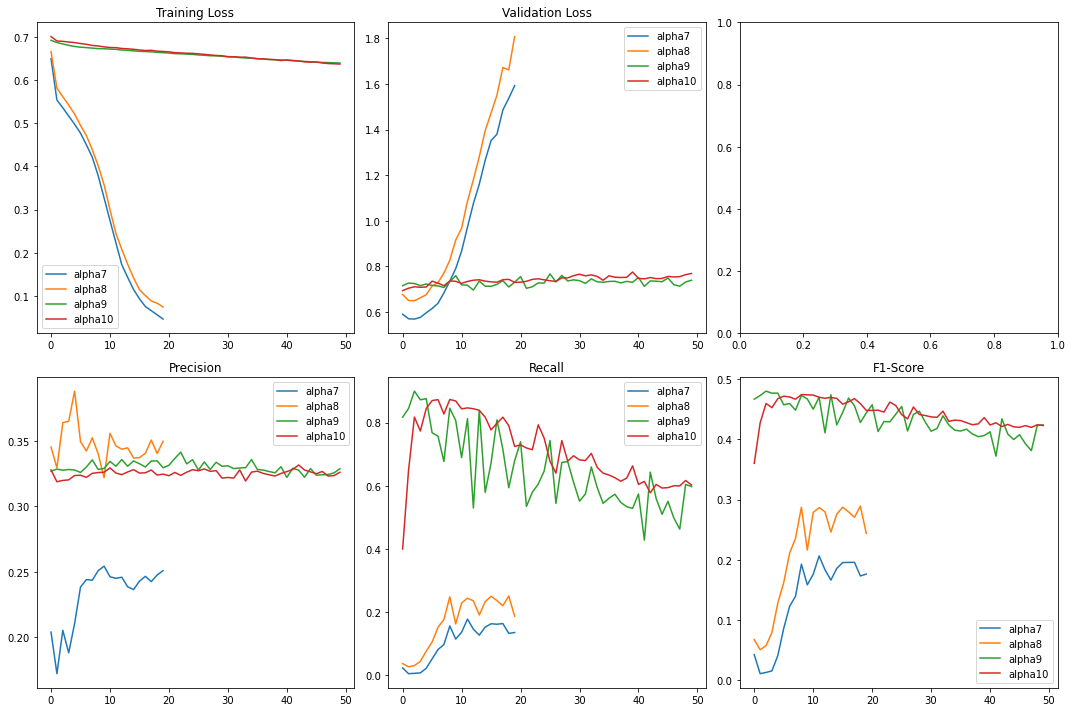

In [11]:
import matplotlib.pyplot as plt

model_ids=[ #'alpha1',
            #'alpha2',
            #'alpha3',
            #'alpha4',  # Data = 20210726
            #'alpha5',  # Data = 20210726
            #'alpha6',  # Data = 20210726
            'alpha7',  # Data = 20210729a
            'alpha8',  # Data = 20210801f
            'alpha9',  # Data = 20210801f - increased pos_weight
            'alpha10',  # Data = 20210801f - NNModelEx
          ]

fig,ax = plt.subplots(2,3,figsize=(15,10))
ax[0][0].set_title("Training Loss")
ax[0][1].set_title("Validation Loss")
ax[1][0].set_title("Precision")
ax[1][1].set_title("Recall")
ax[1][2].set_title("F1-Score")

limit=50

model_configs = []

for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    model_configs.append(config)
    _, _, mean_losses = load_model_only(config)

    metrics = list(zip(*mean_losses))
    tl = metrics[0]
    vl = metrics[1]
    p = metrics[2] if len(metrics)>2 else None
    r = metrics[3] if len(metrics)>3 else None
    f = metrics[4] if len(metrics)>4 else None

    ax[0][0].plot(tl[:limit], label=model_id)
    ax[0][1].plot(vl[:limit], label=model_id)
    if p is not None:
        ax[1][0].plot(p[:limit], label=model_id)
    if r is not None:
        ax[1][1].plot(r[:limit], label=model_id)
    if f is not None:
        ax[1][2].plot(f[:limit], label=model_id)

# ax1.set_ylim(0,0.02)
# ax2.set_ylim(0,0.02)
# ax1.set_yscale('log')
# ax2.set_yscale('log')

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
ax[1][2].legend()
plt.tight_layout()
plt.show()

In [12]:
pd.DataFrame(model_configs)

,model_identifier,model_path,model_type,device,random_seed,max_epochs,do_validate,model_width,optimizer,train_params,test_params,loss
0,alpha7,./models,ResNet28 - Data Variant 20210729a,cuda,0,20,True,1024,"{'type': 'torch.optim.SGD', 'lr': 0.01, 'weigh...","{'batch_size': 2000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_...",NaN
1,alpha8,./models,ResNet28 - Data Variant 20210801f,cuda,0,20,True,1024,"{'type': 'torch.optim.SGD', 'lr': 0.01, 'weigh...","{'batch_size': 2000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_...",NaN
2,alpha9,./models,ResNet28 - Data Variant 20210801f,cuda,0,50,True,10,"{'type': 'torch.optim.SGD', 'lr': 0.1, 'weight...","{'batch_size': 200, 'shuffle': True, 'num_work...","{'batch_size': 200000, 'num_workers': 5, 'pin_...",{'pos_weight': 1}
3,alpha10,./models,ResNet28 - Data Variant 20210801f,cuda,0,50,True,10,"{'type': 'torch.optim.SGD', 'lr': 0.1, 'weight...","{'batch_size': 2000, 'shuffle': True, 'num_wor...","{'batch_size': 200000, 'num_workers': 5, 'pin_...",{'pos_weight': 1}


# Precision Analysis

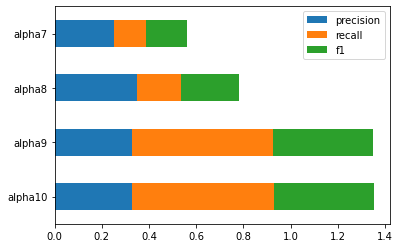

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = {}
recall = {}
f1score = {}

for model_id in model_ids:
    with open(f'models/{model_id}.cfg') as f:
        config = json.load(f)

    _, _, mean_losses = load_model_only(config)

    metrics = list(zip(*mean_losses))
    p = metrics[2][-1] if len(metrics)>2 else 0
    r = metrics[3][-1] if len(metrics)>3 else 0
    f = metrics[4][-1] if len(metrics)>4 else 0
    
    precision[model_id] = round(p,4)
    recall[model_id] = round(r,4)
    f1score[model_id] = round(f,4)
    
metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
torch.cuda.empty_cache()
plt.gca().invert_yaxis()
plt.show()

# Load and Clean Data

In [6]:
# def train_test_split(X, y, train_idx=None, test_idx=None):
#     X_train = X.loc[train_idx]
#     y_train = y.loc[train_idx]
#     X_test = X.loc[test_idx]
#     y_test = y.loc[test_idx]
#     return (X_train, y_train, X_test, y_test)

# def load_split_data(suffix=None, split=False):
#     if suffix==None:
#         suffix='DEFAULT'
        
#     X = pd.read_pickle(f'../data/X_{suffix}.pkl')
#     y = pd.read_pickle(f'../data/y_{suffix}.pkl')
        
#     if split:
#         X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc[:'2019'].index, X.loc['2020':].index)
#         return X_train, y_train, X_test, y_test
#     else:
#         return X, y
    
# X_train, y_train, X_test, y_test = load_split_data(suffix='20210726', split=True)

### Same as above but runs predictions

In [7]:
# from sklearn.metrics import f1_score, precision_score, recall_score

# def get_metrics(model_id, X_test, y_test):
#     with open(f'models/{model_id}.cfg') as f:
#         config = json.load(f)

#     model, scaler, _ = load_model_only(config)
    
#     if scaler is not None:
#         X = scaler.transform(X_test.copy())
#         scaled_X = X.copy()
#     else:
#         X = X_test
    
#     predictions = predict(model, X, y_test, device=config['device'], silent=True)
#     predictions = np.nan_to_num(predictions)
    
#     precision = precision_score(y_test, predictions, zero_division=0)
#     recall = recall_score(y_test, predictions, zero_division=0)
#     f1score = f1_score(y_test, predictions, zero_division=0)
#     return precision, recall, f1score, predictions

# precision = {}
# recall = {}
# f1score = {}   

# for model_id in model_ids:
#     p, r, f, _ = get_metrics(model_id, X_test, y_test)
    
#     precision[model_id] = round(p,4)
#     recall[model_id] = round(r,4)
#     f1score[model_id] = round(f,4)

# metrics = pd.DataFrame({k: [v,recall[k],f1score[k]] for k,v in precision.items()}, index=['precision','recall','f1']).T
# metrics.plot(kind='barh', stacked=True, figsize=(6,len(metrics)))
# torch.cuda.empty_cache()
# plt.gca().invert_yaxis()
# plt.show()